<a href="https://colab.research.google.com/github/iishutov/CV-Project/blob/128-study/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, regularizers
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
! rm -rf sample_data
! rm -rf colored grayscale
! mkdir -p grayscale/train; cd grayscale/train; mkdir empty full/; cd
! mkdir -p grayscale/test; cd grayscale/test; mkdir empty full/; cd
! mkdir colored

train_dir = '/content/colored/train'
test_dir = '/content/colored/test'
train_grayscale_dir = '/content/grayscale/train'
test_grayscale_dir = '/content/grayscale/test'

train_dir_zip = '/content/drive/MyDrive/ML/my-dataset/train.zip'
test_dir_zip = '/content/drive/MyDrive/ML/my-dataset/test.zip'
# import folders from Google Drive with a dataset and unzip them.
for zip_dir, dir in zip((train_dir_zip, test_dir_zip), (train_dir, test_dir)):
  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(dir)

In [3]:
# Converting images to grayscale format.
for colored_dir, grayscale_dir in zip((train_dir, test_dir), (train_grayscale_dir, test_grayscale_dir)):
  for container_class in ('empty', 'full'):
    c_class_dir = os.path.join(colored_dir, container_class)
    g_class_dir = os.path.join(grayscale_dir, container_class)
    for filename in os.listdir(c_class_dir):
      img = cv2.imread(os.path.join(c_class_dir, filename), 0)
      cv2.imwrite(os.path.join(g_class_dir, filename), img)

train_dir = train_grayscale_dir
test_dir = test_grayscale_dir

In [4]:
batch_size = 32
rescale = 1./255
img_height = img_width = 128

In [5]:
# Training dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip=True,
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.2,
    #zoom_range=0.2,
    #fill_mode='nearest',
    #brightness_range=(0.8, 1.2),
    #channel_shift_range=50
)

train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
)

Found 630 images belonging to 2 classes.


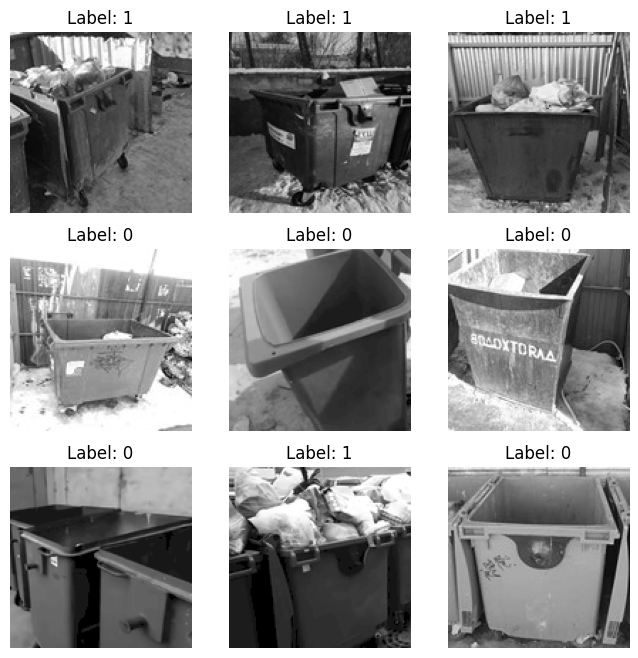

In [6]:
# Show the resulted training dataset after augmentation.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        image, label = train_dataset.next()
        axs[i,j].imshow(image[0], cmap='gray')
        axs[i,j].set_title(f'Label: {(int)(label[0])}')
        axs[i,j].axis('off')
plt.show()

In [7]:
# Testing dataset preprocessing (normalization).
test_datagen = ImageDataGenerator(rescale=rescale)

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 160 images belonging to 2 classes.


In [10]:
# Building the convolutional base.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same', input_shape=(img_height, img_width, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.000), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
# Adding Dense Layers.
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.000)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 64)      

Epoch 1/15
20/20 [==============================] - 26s 1s/step - loss: 0.6751 - accuracy: 0.5778 - val_loss: 0.6651 - val_accuracy: 0.5750
Epoch 2/15
20/20 [==============================] - 27s 1s/step - loss: 0.6518 - accuracy: 0.6222 - val_loss: 0.6454 - val_accuracy: 0.6562
Epoch 3/15
20/20 [==============================] - 25s 1s/step - loss: 0.6313 - accuracy: 0.6460 - val_loss: 0.6105 - val_accuracy: 0.6562
Epoch 4/15
20/20 [==============================] - 26s 1s/step - loss: 0.6011 - accuracy: 0.6984 - val_loss: 0.5619 - val_accuracy: 0.7063
Epoch 5/15
20/20 [==============================] - 26s 1s/step - loss: 0.5358 - accuracy: 0.7349 - val_loss: 0.5128 - val_accuracy: 0.7250
Epoch 6/15
20/20 [==============================] - 30s 2s/step - loss: 0.4822 - accuracy: 0.7794 - val_loss: 0.4771 - val_accuracy: 0.7625
Epoch 7/15
20/20 [==============================] - 24s 1s/step - loss: 0.3958 - accuracy: 0.8333 - val_loss: 0.4333 - val_accuracy: 0.7750
Epoch 8/15
20/20 [==

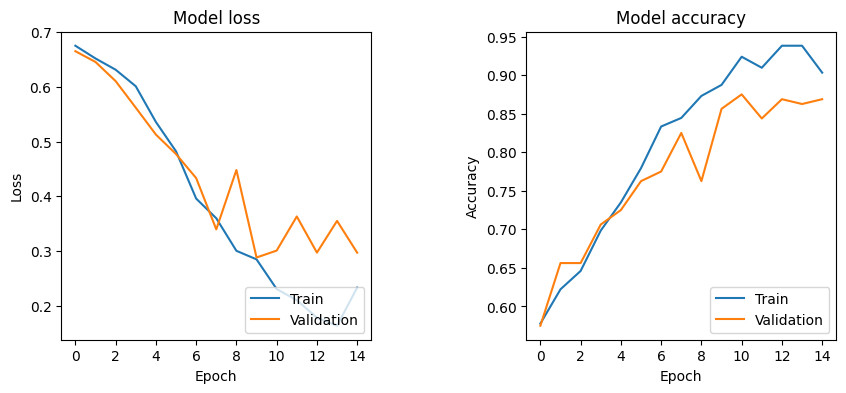

In [11]:
# Training the model.
model.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = model.fit(train_dataset, epochs=15, validation_data=test_dataset)
#

# Visualizing loss and accuracy.
fig, (axs_loss, axs_acc) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axs_loss.set_title('Model loss')
axs_loss.set_ylabel('Loss')
axs_loss.set_xlabel('Epoch')
axs_loss.plot(history.history['loss'], label='Train')
axs_loss.plot(history.history['val_loss'], label='Validation')
axs_loss.legend(loc='lower right')
axs_loss.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axs_acc.set_title('Model accuracy')
axs_acc.set_ylabel('Accuracy')
axs_acc.set_xlabel('Epoch')
axs_acc.plot(history.history['accuracy'], label='Train')
axs_acc.plot(history.history['val_accuracy'], label='Validation')
axs_acc.legend(loc='lower right')
axs_acc.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

fig.subplots_adjust(wspace=0.5)
plt.show()

10/10 [==============================] - 1s 43ms/step


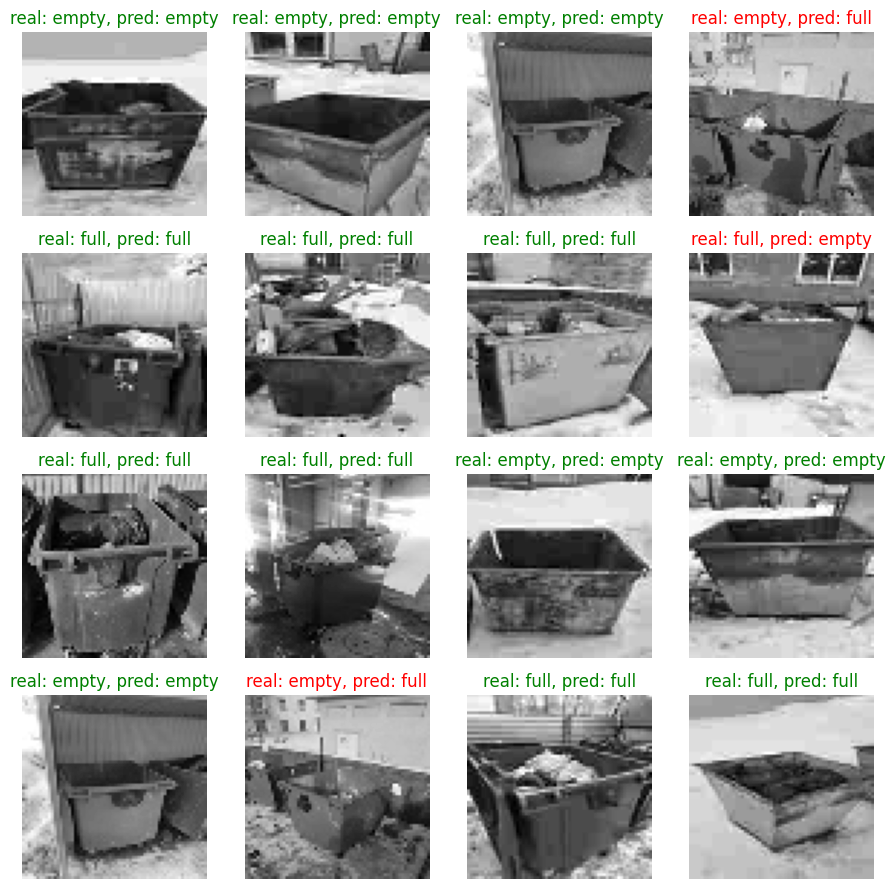

In [ ]:
# Result.
predictions = model.predict(test_dataset)

idx = 0
rng = np.random.default_rng()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(11,11))

for i in range(4):
  for j in range(4):
    image, label = test_dataset.next()
    _batch_size = label.shape[0]
    
    local_idx = (int)(_batch_size * rng.uniform())
    global_idx = (idx + local_idx) % len(predictions)

    real_class = 'full' if np.round(label[local_idx]) else 'empty'
    predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

    axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
      .set_color('green' if real_class == predicted_class else 'red')
    axs[i,j].imshow(image[local_idx], cmap='gray')
    axs[i,j].axis('off')

    idx += _batch_size

plt.show()